<a href="https://colab.research.google.com/github/prakyaths/HumanEmotionAI/blob/feature%2FImplement-lenet-based-HES-detection/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import albumentations as A
import datetime
import os
import io
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, RandomContrast, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, Loss, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall, CategoricalAccuracy, TopKCategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


###WandB install and login

In [2]:
!pip install wandb

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
wandb.init(project="Human_Emotion_Detection", entity="PrakyathDl")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: prakyaths (PrakyathDl). Use `wandb login --relogin` to force relogin


In [5]:
wandb.config = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}
CONFIGURATION = wandb.config

###Dataset Download

In [6]:
!pip install -q kaggle

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 309M/309M [00:16<00:00, 22.9MB/s]
100% 309M/309M [00:16<00:00, 19.3MB/s]


In [10]:
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [11]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [13]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [14]:
for i in val_dataset.take(1):
  print(i[1].shape)

(32, 3)


###Visualize dataset

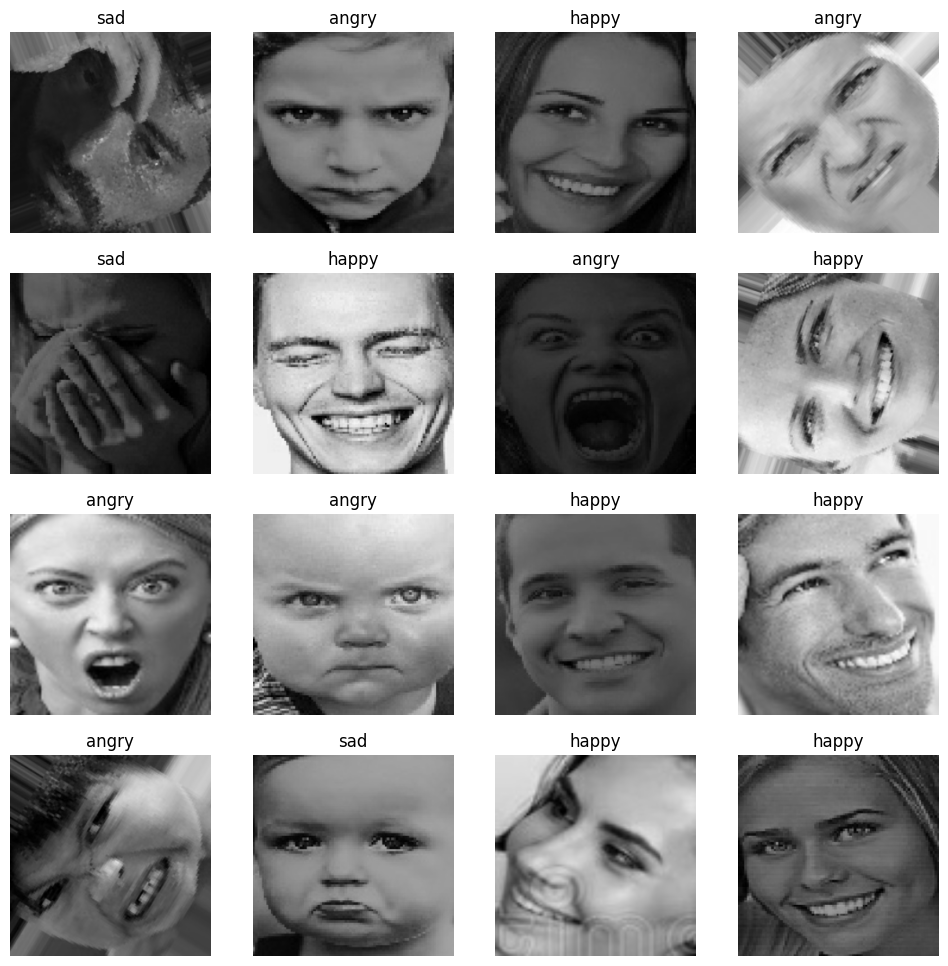

In [15]:
plt.figure(figsize=(12,12))
for (images,labels) in train_dataset.take(1):
  for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i], axis=0).numpy()])
    plt.axis('off')

###Data Augmentation

In [16]:
# augment with tf.keras.layers class
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training=True), label

###Cutmix Augmentation

In [17]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip(train_dataset_1, train_dataset_2)

In [18]:
IM_SIZE = CONFIGURATION["IM_SIZE"]
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
  #print(r_x, r_y)

  r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
  r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if(r_h ==0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [19]:
def cutmixAugmentation(train_dataset_1, train_dataset_2):
  (image1, label1), (image2, label2) =  train_dataset_1, train_dataset_2
  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]
  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)
  crop_1 = tf.image.crop_to_bounding_box(image1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image1-pad_1+pad_2

  lamda = tf.cast(1 - ((r_w*r_h)/(IM_SIZE*IM_SIZE)), dtype=tf.float32)
  label = lamda*tf.cast(label1, dtype=tf.float32)  + (1 - lamda)*tf.cast(label2, dtype=tf.float32)
  return image, label

###Dataset preparation

In [20]:
train_dataset = (
    #train_dataset
    mixed_dataset
    #.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .map(cutmixAugmentation, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [21]:
val_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
IM_SIZE = CONFIGURATION['IM_SIZE']
# resize with layers
resizeAndRescaleLayers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255),
])

#def resizeAndRescaleLayer(image, label):
#  return resizeAndRescaleLayers(image, training=True), label

###TF Records

In [ ]:
train_dataset = (
    #train_dataset
    mixed_dataset
    #.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .map(cutmixAugmentation, num_parallel_calls = tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)  #The prefetching need not be done since we do unbatching for TF Records
)

In [ ]:
val_dataset = (
    val_dataset
    #.prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset = (
    train_dataset
    .unbatch()
)

In [ ]:
val_dataset = (
    val_dataset
    .unbatch()
)

In [ ]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
val_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS)] )

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resizeAndRescaleLayers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

###Model

In [23]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resizeAndRescaleLayers,

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense( CONFIGURATION['NUM_CLASSES'], activation = "softmax"),

])

lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

###ResNet34 (Custom)

In [38]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [39]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [40]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34_model = ResNet34()
resnet_34_model(tf.zeros([1,256,256,3]), training = False)
resnet_34_model.summary()

###Tensorboard

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME + '/metrics'

In [ ]:
LOG_DIR = "drive/MyDrive/TensorflowModels/model_logs/" + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
print(LOG_DIR)

###Training

In [24]:
loss_function = CategoricalCrossentropy(from_logits=False)

In [25]:
metrics=[CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [26]:
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics=metrics
)

In [27]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=CONFIGURATION["N_EPOCHS"], verbose=True, callbacks=[WandbMetricsLogger()])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 154s 661ms/step - accuracy: 0.4287 - loss: 1.1877 - top_k_accuracy: 0.7486 - val_accuracy: 0.5145 - val_loss: 1.0158 - val_top_k_accuracy: 0.8082
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 184s 617ms/step - accuracy: 0.5757 - loss: 0.9398 - top_k_accuracy: 0.8392 - val_accuracy: 0.5759 - val_loss: 0.9205 - val_top_k_accuracy: 0.8213
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 134s 625ms/step - accuracy: 0.6016 - loss: 0.8999 - top_k_accuracy: 0.8567 - val_accuracy: 0.6321 - val_loss: 0.8060 - val_top_k_accuracy: 0.8802
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 135s 594ms/step - accuracy: 0.6276 - loss: 0.8732 - top_k_accuracy: 0.8704 - val_accuracy: 0.5632 - val_loss: 0.8924 - val_top_k_accuracy: 0.8613
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 150s 625ms/step - accuracy: 0.6440 - loss: 0.8494 - top_k_accuracy: 0.8854 - val_accuracy: 0.6133 - val_loss: 0.8413 - val_top_k_accuracy: 0.8472
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 137s 606ms/step - accuracy: 0.

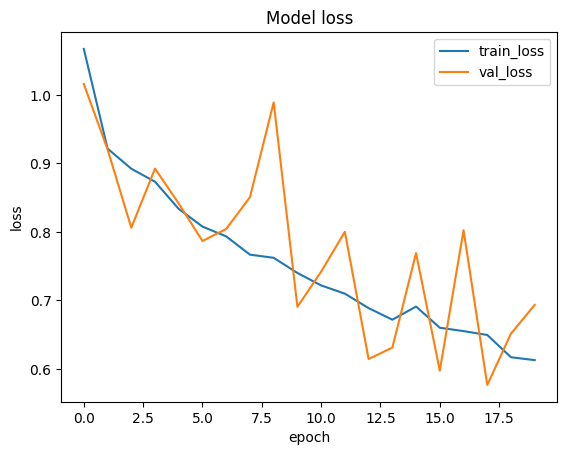

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

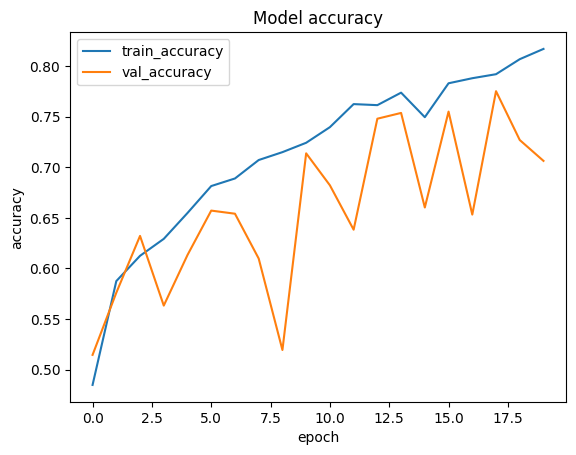

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

###Evaluation

In [31]:
lenet_model.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6934 - loss: 0.7181 - top_k_accuracy: 0.8978


[0.6934434771537781, 0.7063213586807251, 0.9029850959777832]

###Test

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg")
test_image_tensor = tf.constant(test_image, dtype=tf.float32)
test_image_tensor = tf.expand_dims(test_image_tensor, axis=0)
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model.predict(test_image_tensor), axis=-1).numpy()[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
angry


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


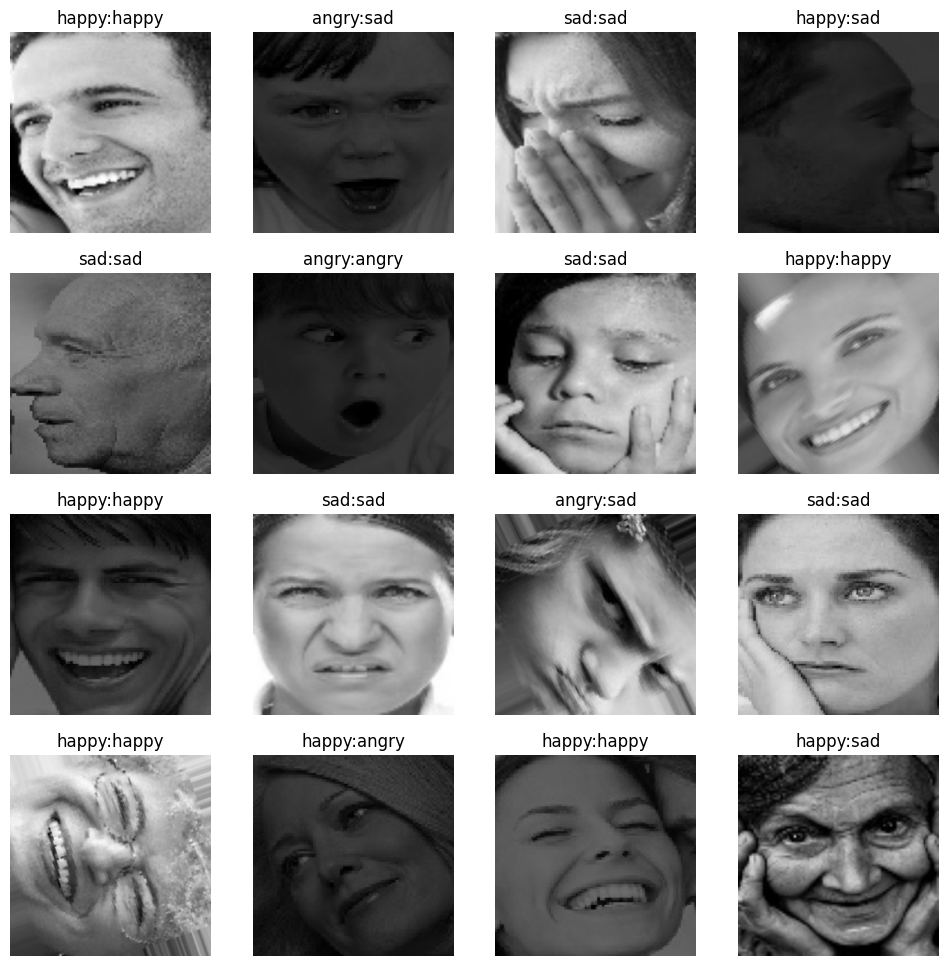

In [32]:
plt.figure(figsize=(12,12))
for (images,labels) in val_dataset.take(1):
  for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(str(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i], axis=0).numpy()]) + ":" + str(CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model.predict(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]]))
    plt.axis('off')

###Confusion Matrix

In [ ]:
predicted=[]
labels=[]
for image, label in val_dataset:
  predicted.append(lenet_model.predict(image))
  labels.append(label.numpy())

In [34]:
print(np.argmax(predicted[:-1], axis=-1).flatten())
print(np.argmax(labels[:-1], axis=-1).flatten())

[2 1 2 ... 1 1 1]
[2 2 1 ... 1 1 1]


In [35]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[245 116 154]
 [ 46 773 187]
 [ 51 115 591]]


Text(0.5, 58.7222222222222, 'Predicted')

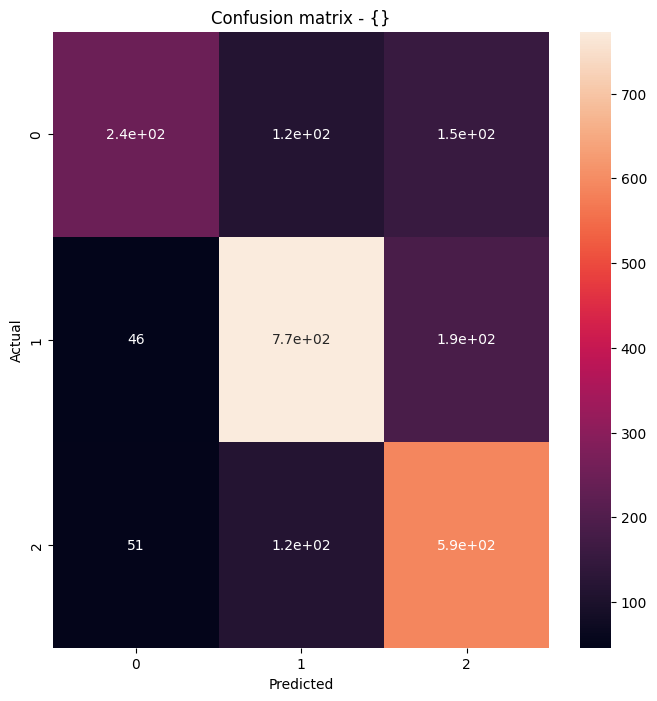

In [36]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [37]:
lenet_model.save("drive/MyDrive/TensorflowModels/lenetModel_humanEmotion_70TestAccu.hdf5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
